In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.convolutional import Conv3D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import keras
from functools import partial

In [4]:
import keras.models as km
import keras.layers as kl
import keras.activations as ka
import keras.layers.advanced_activations as kla

In [5]:
import keras.backend as K

In [6]:
from keras.utils import multi_gpu_model

In [7]:
#from tensorflow.python.client import device_lib

In [8]:
from IPython import display
import time

In [6]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2436406822065410352, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14615607564618076357
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 806596212033273996
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10913290650
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5453577826141622531
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10913290650
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 i

In [9]:
from keras.layers.merge import _Merge

In [10]:
class LayerNormalization(kl.Layer):

    def __init__(self,
                 center=True,
                 scale=True,
                 epsilon=None,
                 gamma_initializer='ones',
                 beta_initializer='zeros',
                 gamma_regularizer=None,
                 beta_regularizer=None,
                 gamma_constraint=None,
                 beta_constraint=None,
                 **kwargs):
        """Layer normalization layer
        See: [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf)
        :param center: Add an offset parameter if it is True.
        :param scale: Add a scale parameter if it is True.
        :param epsilon: Epsilon for calculating variance.
        :param gamma_initializer: Initializer for the gamma weight.
        :param beta_initializer: Initializer for the beta weight.
        :param gamma_regularizer: Optional regularizer for the gamma weight.
        :param beta_regularizer: Optional regularizer for the beta weight.
        :param gamma_constraint: Optional constraint for the gamma weight.
        :param beta_constraint: Optional constraint for the beta weight.
        :param kwargs:
        """
        super(LayerNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.center = center
        self.scale = scale
        if epsilon is None:
            epsilon = K.epsilon() * K.epsilon()
        self.epsilon = epsilon
        self.gamma_initializer = keras.initializers.get(gamma_initializer)
        self.beta_initializer = keras.initializers.get(beta_initializer)
        self.gamma_regularizer = keras.regularizers.get(gamma_regularizer)
        self.beta_regularizer = keras.regularizers.get(beta_regularizer)
        self.gamma_constraint = keras.constraints.get(gamma_constraint)
        self.beta_constraint = keras.constraints.get(beta_constraint)
        self.gamma, self.beta = None, None

    def get_config(self):
        config = {
            'center': self.center,
            'scale': self.scale,
            'epsilon': self.epsilon,
            'gamma_initializer': keras.initializers.serialize(self.gamma_initializer),
            'beta_initializer': keras.initializers.serialize(self.beta_initializer),
            'gamma_regularizer': keras.regularizers.serialize(self.gamma_regularizer),
            'beta_regularizer': keras.regularizers.serialize(self.beta_regularizer),
            'gamma_constraint': keras.constraints.serialize(self.gamma_constraint),
            'beta_constraint': keras.constraints.serialize(self.beta_constraint),
        }
        base_config = super(LayerNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        self.input_spec = keras.engine.InputSpec(shape=input_shape)
        shape = input_shape[-1:]
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape,
                initializer=self.gamma_initializer,
                regularizer=self.gamma_regularizer,
                constraint=self.gamma_constraint,
                name='gamma',
            )
        if self.center:
            self.beta = self.add_weight(
                shape=shape,
                initializer=self.beta_initializer,
                regularizer=self.beta_regularizer,
                constraint=self.beta_constraint,
                name='beta',
            )
        super(LayerNormalization, self).build(input_shape)

    def call(self, inputs, training=None):
        mean = K.mean(inputs, axis=-1, keepdims=True)
        variance = K.mean(K.square(inputs - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        outputs = (inputs - mean) / std
        if self.scale:
            outputs *= self.gamma
        if self.center:
            outputs += self.beta
            
        return outputs

In [11]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def _compute_gradients(tensor, var_list):
    grads = K.gradients(tensor, var_list)
    return [grad if grad is not None else K.zeros_like(var)
            for var, grad in zip(var_list, grads)]

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated 3D image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((8, 1, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    """
    Computes gradient penalty based on prediction and weighted real / fake samples
    """
    gradients = _compute_gradients(y_pred, [averaged_samples])[0]
    #gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

In [12]:
def batchnorm(center=True, momentum=0.8):
    return kl.BatchNormalization(center=center, momentum=momentum)

def clayer(nfeatures, kernel_size=(3, 3, 3), strides=(1,1, 1), use_bias=True, **kwargs):
    
    return kl.Conv3D(nfeatures,
                     kernel_size=kernel_size,strides=strides, 
                     use_bias=use_bias, padding='same', **kwargs)

def NonLinearity(activation='relu'):
    
    if activation == 'relu':
        return kl.Activation('relu')
    elif activation == 'lrelu':
        return kla.LeakyReLU(alpha=0.2)

def ResBlock(x, nf, dropout=None, norm='batch', activation='relu', **kwargs):
    
    shortcut = x
    x = clayer(nf, **kwargs)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = NonLinearity(activation=activation)(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = NonLinearity(activation=activation)(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    
    return x

def DownBlock(x, nf, dropout=None, norm=None, activation='lrelu', **kwargs):
    """
    This reduces the dimensionality using convolutions.
    """
    
    shortcut = clayer(nf, kernel_size=(1,1,1), strides=(2,2,2), **kwargs)(x)
    x = clayer(nf, kernel_size=(2,2,2), strides=(2,2,2), **kwargs)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = NonLinearity(activation=activation)(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = NonLinearity(activation=activation)(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
        
    return x

In [13]:
def get_critic(input_shape, base_features=32, norm=None):
    """
    A simple discriminator.
    """
    
    input_state = kl.Input(shape=input_shape)

    #Input layer
    x = kl.Conv3D(base_features, (3,3,3), padding='same', strides=2)(input_state)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv3D(base_features*2, (3,3,3), padding='same', strides=2)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv3D(base_features*4, (3,3,3), padding='same', strides=2)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv3D(base_features*8, (3,3,3), padding='same', strides=1)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
        
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Dropout(0.25)(x)
    x = kl.Flatten()(x)
    #Linear activation for the critic
    x = kl.Dense(units=1)(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model

def get_critic2(input_shape, base_features=32, norm=None):
    """
    A less simple critic discriminator.
    """
    
    input_state = kl.Input(shape=input_shape)

    #Input layer
    x = kl.Conv3D(base_features, (7,7,7), padding='same', strides=2)(input_state)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv3D(base_features*2, (5,5,5), padding='same', strides=2)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv3D(base_features*4, (3,3,3), padding='same', strides=2)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    x = kl.Conv3D(base_features*8, (1,1,1), padding='same', strides=1)(x)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = kla.LeakyReLU(alpha=0.2)(x)
    
    x = kl.Dropout(0.25)(x)
    x = kl.Flatten()(x)
    #Linear activation for the critic
    x = kl.Dense(units=1)(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model


def get_critic3(input_shape, nlevels=3, base_features=32, norm=None, activation='lrelu', dropout=None, **kwargs):
    """
    Returns a 2D CNN critic based on the ResNet model.
    Parameters
    ---------
    input_shape : np.array((3))
        Specifies the size of the input data, usually (weight, height, 1)
    
    nlevels : int (optional)
        The number of times (-1) to downsample the resolution
        Default 4.
    base_features: int (optional)
        The number of features the input layer should learn.
        Default 32.
    Returns
    -------
    model :
        The keras model.
    """
    
    input_state = kl.Input(shape=input_shape)

    #Input layer
    x = kl.Conv3D(base_features, (7,7,7), use_bias=False, padding='same', **kwargs)(input_state)
    if norm=='batch':
        x = kl.BatchNormalization(momentum=0.8)(x)
    elif norm=='layer':
        x = LayerNormalization()(x)
    x = NonLinearity()(x)

    for level in range(nlevels):
        
        if level != 0:
            # This layer ups the number of features while downsampling spatially
            x = DownBlock(x, base_features*2**level, dropout=dropout, 
                          norm=norm, activation=activation, **kwargs)
    
        x = ResBlock(x, base_features*2**level, dropout=dropout, 
                     norm=norm, activation=activation, **kwargs)
        x = ResBlock(x, base_features*2**level, dropout=dropout, 
                     norm=norm, activation=activation, **kwargs)
        #if level in [1, 2]:
        #    x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)

    #x = kl.GlobalAvgPool3D()(x)
    x = kl.Dropout(0.25)(x)
    x = kl.Flatten()(x)
    x = kl.Dense(1)(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model


In [14]:
#Build Generator which takes noise as input
#model.add(Dense(256, input_dim=latent_dim))

def UpBlock(x, nf, dropout=None, **kwargs):
    """
    This increases the dimensionality using transposed convolutions.
    """
    
    shortcut = kl.Conv3DTranspose(nf, kernel_size=(1,1,1), strides=(2,2,2), **kwargs)(x)
    
    x = kl.Conv3DTranspose(nf, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(x)
    x = batchnorm()(x)
    x = NonLinearity()(x)
    
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    x = batchnorm()(x)
    x = NonLinearity()(x)
    
    return x

def get_generator(input_shape, image_shape, nlevels=4, base_features=32, dropout=None, **kwargs):
    
    """
    Takes in noise and returns an image
    """

    # Get the input and reshape it into an image of the right shape.
    input_state = kl.Input(shape=input_shape)
    
    ii_width = image_shape[0]//2**nlevels
    ii_height = image_shape[1]//2**nlevels
    ii_depth = image_shape[2]//2**nlevels
    
    x = kl.Dense(units=ii_depth*ii_width*ii_height*base_features)(input_state)
    x = NonLinearity()(x)
    x = kl.Reshape((ii_width, ii_height, ii_depth, base_features))(x)
    
    #x = ResBlock(x, base_features, dropout=dropout, **kwargs)
    #x = ResBlock(x, base_features, dropout=dropout, **kwargs)

    for level in range(nlevels):
        
        #Reduce nfeatures by half
        x = UpBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
    
        x = ResBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
        x = ResBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
            
    x = clayer(1, activation='tanh')(x)
        
    # This last layer is linear
    #x = kl.Conv2D(1, kernel_size=(7,7), strides=(1,1), padding='same', activation='tanh')(x)
    #x = kl.Conv2D(1, kernel_size=(1,1), strides=(1,1), padding='same')(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model

## Build and Compile

In [15]:
model=None
K.clear_session()

In [16]:
# Define some metadata
img_rows = 64
img_cols = 64
img_depth = 64
channels = 1
img_shape = (img_rows, img_cols, img_depth, channels)
latent_dim = 100

### Wasserstein GAN

In [17]:
#Ok let's build and compile everything
#self.n_critic = 5
#optimizer = RMSprop(lr=0.00005)
#optimizer = RMSprop(lr=0.00005, decay=5e-5)
#optimizer = RMSprop(lr=0.00005)

# Number of gpus
ngpus = 1

#optimizer = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9, decay=1e-5)
#optimizer = Adam(lr=1e-4, beta_1=0.5, beta_2=0.999)
optimizer = Adam(lr=2e-4, beta_1=0., beta_2=0.9, decay=1e-5)

# Build the critic
#critic = get_critic(input_shape=img_shape, base_features=32)
critic = get_critic2(input_shape=img_shape, base_features=32)
#critic = get_critic3(input_shape=img_shape, base_features=16, nlevels=2, norm='layer', activation='lrelu')

# Build the generator
generator = get_generator(input_shape=(latent_dim,), base_features=32*2**4,
                          image_shape=(img_rows, img_cols, img_depth), nlevels=4)

#-------------------------------
# Construct Computational Graph
#       for the Critic
#-------------------------------

# Freeze generator's layers while training critic
generator.trainable = False

# Image input (real sample)
real_img = Input(shape=img_shape)

# Noise input
z_disc = Input(shape=(latent_dim,))
# Generate image based of noise (fake sample)
fake_img = generator(z_disc)

# Discriminator determines validity of the real and fake images
fake = critic(fake_img)
valid = critic(real_img)

# Construct weighted average between real and fake images
interpolated_img = RandomWeightedAverage()([real_img, fake_img])
# Determine validity of weighted sample
validity_interpolated = critic(interpolated_img)

# Use Python partial to provide loss function with additional
# 'averaged_samples' argument
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=interpolated_img)
partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

critic_model = Model(inputs=[real_img, z_disc],
                     outputs=[valid, fake, validity_interpolated])
if ngpus > 1:
    critic_model = multi_gpu_model(critic_model, gpus=ngpus)
critic_model.compile(loss=[wasserstein_loss,
                           wasserstein_loss,
                           partial_gp_loss],
                     optimizer=optimizer,
                     loss_weights=[1, 1, 10])
#-------------------------------
# Construct Computational Graph
#         for Generator
#-------------------------------

# For the generator we freeze the critic's layers
critic.trainable = False
generator.trainable = True

# Sampled noise for input to generator
z_gen = Input(shape=(latent_dim,))
# Generate images based of noise
img = generator(z_gen)
# Discriminator determines validity
valid = critic(img)
# Defines generator model
generator_model = Model(z_gen, valid)
if ngpus > 1:
    generator_model = multi_gpu_model(generator_model, gpus=ngpus)
generator_model.compile(loss=wasserstein_loss, optimizer=optimizer)

In [18]:
import glob
import h5py

In [19]:
def split3d(arr3d, nchunks):
    arr3ds = [arr3d,]
    for di in range(3):
        arr3dsi = []
        for ai in range(len(arr3ds)):
            arr3dsi.extend(np.split(arr3ds[ai], nchunks, axis=di))
        arr3ds = arr3dsi

    del arr3d
    
    return arr3ds

In [3]:
import h5py

In [4]:
# Load the data
fp = "/work/06147/pberger/maverick2/gadget_runs/cosmo1/n512_512Mpc_cosmo1_z0_gridpart.h5"

data = h5py.File(fp, 'r')

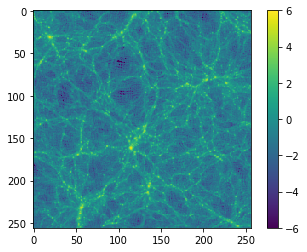

In [17]:
imshow(np.log(1e-15 + np.mean(data['seed1'][256-10:256+10, :256, :256], axis=0)), vmin=-6, vmax=6)
colorbar()

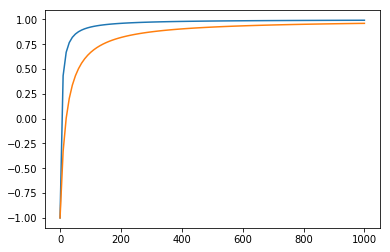

In [21]:
def squash(x, a=4.0):
    
    return 2*x / (x + a) - 1

def squash_inv(y, a=4.0):
    
    return -a*(y+1)/(y-1)

plot(np.linspace(0, 1000, 100), squash(np.linspace(0, 1000, 100)))
plot(np.linspace(0, 1000, 100), squash(np.linspace(0, 1000, 100), a=20.0))

In [22]:
delta = []
for dk in list(data.keys()):
    delta_i = squash(data[dk][:])
    delta_i = np.array(split3d(delta_i, 8))
    delta.extend(delta_i)
delta = np.array(delta)

data.close()

/home1/06147/pberger/.virtualenvs/tensorflow/lib/python2.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: 0/409: [D loss: -81.254501] [G loss: -3.145410]
0: 1/409: [D loss: -1603.892090] [G loss: -1592.640625]
0: 2/409: [D loss: -1722.865234] [G loss: -1112.893066]
0: 3/409: [D loss: -829.629333] [G loss: -1071.817139]
0: 4/409: [D loss: -418.889343] [G loss: -1044.195435]
0: 5/409: [D loss: -160.282639] [G loss: -898.083008]
0: 6/409: [D loss: -254.736359] [G loss: -433.197174]
0: 7/409: [D loss: -101.479935] [G loss: -516.325806]
0: 8/409: [D loss: -113.754379] [G loss: -369.568390]
0: 9/409: [D loss: -154.391586] [G loss: -240.522186]
0: 10/409: [D loss: -75.029526] [G loss: -568.526733]
0: 11/409: [D loss: -51.299591] [G loss: 5.033432]
0: 12/409: [D loss: -91.492653] [G loss: -746.632080]
0: 13/409: [D loss: -52.186680] [G loss: -76.766457]
0: 14/409: [D loss: -39.604404] [G loss: -570.424316]
0: 15/409: [D loss: -71.724457] [G loss: 462.502228]
0: 16/409: [D loss: -75.216736] [G loss: -582.379028]
0: 17/409: [D loss: -59.644180] [G loss: 166.124130]
0: 18/409: [D loss: -44.015198]

0: 153/409: [D loss: -44.532005] [G loss: -618.608398]
0: 154/409: [D loss: -34.938274] [G loss: 549.614075]
0: 155/409: [D loss: -23.087265] [G loss: -62.648815]
0: 156/409: [D loss: -19.377008] [G loss: 335.337433]
0: 157/409: [D loss: -34.351166] [G loss: -414.466370]
0: 158/409: [D loss: -47.961788] [G loss: 1170.371338]
0: 159/409: [D loss: -58.982780] [G loss: -744.198547]
0: 160/409: [D loss: -22.614429] [G loss: 557.398560]
0: 161/409: [D loss: -19.945566] [G loss: -378.346985]
0: 162/409: [D loss: -5.182918] [G loss: 234.513153]
0: 163/409: [D loss: -15.424497] [G loss: -125.415390]
0: 164/409: [D loss: -23.560890] [G loss: 255.175339]
0: 165/409: [D loss: -23.689518] [G loss: -391.679565]
0: 166/409: [D loss: -28.348637] [G loss: 421.884583]
0: 167/409: [D loss: -23.925682] [G loss: -383.222046]
0: 168/409: [D loss: -1.528793] [G loss: 75.860229]
0: 169/409: [D loss: -23.465796] [G loss: 107.895111]
0: 170/409: [D loss: -19.650021] [G loss: -144.089798]
0: 171/409: [D loss: -

0: 304/409: [D loss: -27.857323] [G loss: -565.310913]
0: 305/409: [D loss: -15.510276] [G loss: 381.484100]
0: 306/409: [D loss: -15.963697] [G loss: -253.496704]
0: 307/409: [D loss: -20.047407] [G loss: 588.546753]
0: 308/409: [D loss: -4.194000] [G loss: -316.722137]
0: 309/409: [D loss: -18.082727] [G loss: 468.492065]
0: 310/409: [D loss: -17.088099] [G loss: -90.792229]
0: 311/409: [D loss: -9.574364] [G loss: -75.355263]
0: 312/409: [D loss: -13.037760] [G loss: 96.042053]
0: 313/409: [D loss: -8.697600] [G loss: 38.496880]
0: 314/409: [D loss: -0.836325] [G loss: 124.418411]
0: 315/409: [D loss: -17.412434] [G loss: 605.789917]
0: 316/409: [D loss: -88.047745] [G loss: -1077.064941]
0: 317/409: [D loss: -24.539312] [G loss: 474.660095]
0: 318/409: [D loss: -10.379219] [G loss: 81.903091]
0: 319/409: [D loss: -18.032110] [G loss: 189.391266]
0: 320/409: [D loss: -19.574615] [G loss: 26.094343]
0: 321/409: [D loss: -6.886459] [G loss: -42.690598]
0: 322/409: [D loss: -22.014307]

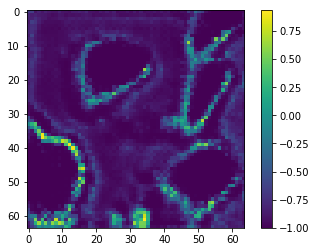

1: 0/409: [D loss: -27.310593] [G loss: -462.979675]
1: 1/409: [D loss: -48.477879] [G loss: 1047.387695]
1: 2/409: [D loss: -25.464529] [G loss: -382.562561]
1: 3/409: [D loss: -21.543602] [G loss: 254.046021]
1: 4/409: [D loss: -28.969814] [G loss: 0.212205]
1: 5/409: [D loss: -7.995481] [G loss: 278.167358]
1: 6/409: [D loss: -15.220762] [G loss: -247.479919]
1: 7/409: [D loss: 14.487080] [G loss: 118.226654]
1: 8/409: [D loss: -17.821342] [G loss: 48.037205]
1: 9/409: [D loss: 1.112414] [G loss: 39.579506]
1: 10/409: [D loss: -14.912949] [G loss: 526.633423]
1: 11/409: [D loss: -28.578835] [G loss: -532.972656]
1: 12/409: [D loss: -10.944322] [G loss: 228.278992]
1: 13/409: [D loss: -7.672391] [G loss: -95.399628]
1: 14/409: [D loss: -43.297199] [G loss: 702.131104]
1: 15/409: [D loss: -28.691504] [G loss: -763.486938]
1: 16/409: [D loss: -14.190303] [G loss: 133.481995]
1: 17/409: [D loss: 9.704662] [G loss: 159.288910]
1: 18/409: [D loss: 0.340192] [G loss: -66.974625]
1: 19/409:

1: 155/409: [D loss: -11.495883] [G loss: -178.131393]
1: 156/409: [D loss: -24.978662] [G loss: 248.881134]
1: 157/409: [D loss: -14.150731] [G loss: -87.585831]
1: 158/409: [D loss: -11.393746] [G loss: 237.698486]
1: 159/409: [D loss: -18.181637] [G loss: -61.146301]
1: 160/409: [D loss: -23.957497] [G loss: 453.673584]
1: 161/409: [D loss: -22.070044] [G loss: -621.683105]
1: 162/409: [D loss: -12.754820] [G loss: 386.344177]
1: 163/409: [D loss: -15.604836] [G loss: -64.137238]
1: 164/409: [D loss: -49.080330] [G loss: 666.767517]
1: 165/409: [D loss: -21.860260] [G loss: -627.666321]
1: 166/409: [D loss: -7.352835] [G loss: 99.674316]
1: 167/409: [D loss: -14.179248] [G loss: 273.369385]
1: 168/409: [D loss: -8.038295] [G loss: -286.653931]
1: 169/409: [D loss: -15.870577] [G loss: 291.749786]
1: 170/409: [D loss: -5.264266] [G loss: -197.695663]
1: 171/409: [D loss: -5.615132] [G loss: 225.504303]
1: 172/409: [D loss: -20.530039] [G loss: 17.570017]
1: 173/409: [D loss: -21.8273

1: 308/409: [D loss: -3.081642] [G loss: -55.118526]
1: 309/409: [D loss: -13.607390] [G loss: 102.562271]
1: 310/409: [D loss: 1.805398] [G loss: 164.983856]
1: 311/409: [D loss: -3.754533] [G loss: 43.823761]
1: 312/409: [D loss: -22.326803] [G loss: 598.035767]
1: 313/409: [D loss: -33.062683] [G loss: -585.863525]
1: 314/409: [D loss: -50.915691] [G loss: 961.138611]
1: 315/409: [D loss: -14.253786] [G loss: 77.286026]
1: 316/409: [D loss: -16.622644] [G loss: 219.551224]
1: 317/409: [D loss: -15.472485] [G loss: 180.353333]
1: 318/409: [D loss: -29.721348] [G loss: 346.404846]
1: 319/409: [D loss: -22.672291] [G loss: -419.891510]
1: 320/409: [D loss: -15.447539] [G loss: 518.395691]
1: 321/409: [D loss: -13.747873] [G loss: -201.936615]
1: 322/409: [D loss: -34.844719] [G loss: 607.955200]
1: 323/409: [D loss: -12.100075] [G loss: -408.667206]
1: 324/409: [D loss: -1.172030] [G loss: 322.954529]
1: 325/409: [D loss: -1.426489] [G loss: 201.051758]
1: 326/409: [D loss: -11.207254]

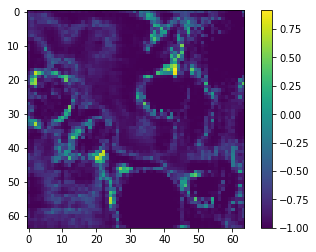

2: 0/409: [D loss: -55.094532] [G loss: 805.602966]
2: 1/409: [D loss: -9.039932] [G loss: -527.518066]
2: 2/409: [D loss: -10.161153] [G loss: 170.824615]
2: 3/409: [D loss: -14.467044] [G loss: 23.284031]
2: 4/409: [D loss: -11.094942] [G loss: -0.464257]
2: 5/409: [D loss: -0.660482] [G loss: 120.822662]
2: 6/409: [D loss: -15.502908] [G loss: 75.893478]
2: 7/409: [D loss: -14.250001] [G loss: -15.706240]
2: 8/409: [D loss: 5.141010] [G loss: 121.080490]
2: 9/409: [D loss: 9.929268] [G loss: -172.475647]
2: 10/409: [D loss: -16.350464] [G loss: 340.815857]
2: 11/409: [D loss: -9.525461] [G loss: -135.149567]
2: 12/409: [D loss: -16.077904] [G loss: 160.447937]
2: 13/409: [D loss: -10.727924] [G loss: 83.161896]
2: 14/409: [D loss: -8.676231] [G loss: -129.539749]
2: 15/409: [D loss: -52.666584] [G loss: 373.132294]
2: 16/409: [D loss: -33.729069] [G loss: -128.479950]
2: 17/409: [D loss: 61.551285] [G loss: 414.011261]
2: 18/409: [D loss: -9.464890] [G loss: -230.979736]
2: 19/409: 

2: 156/409: [D loss: 20.289375] [G loss: -58.801350]
2: 157/409: [D loss: 1.671463] [G loss: -139.124603]
2: 158/409: [D loss: -10.017750] [G loss: 272.865906]
2: 159/409: [D loss: -16.558092] [G loss: 100.927124]
2: 160/409: [D loss: -5.292440] [G loss: 92.502335]
2: 161/409: [D loss: -6.445339] [G loss: 28.449196]
2: 162/409: [D loss: -13.594435] [G loss: 66.236763]
2: 163/409: [D loss: -22.693251] [G loss: 292.150635]
2: 164/409: [D loss: -14.473125] [G loss: -82.152008]
2: 165/409: [D loss: 3.211132] [G loss: 67.440025]
2: 166/409: [D loss: -19.078264] [G loss: 2.626312]
2: 167/409: [D loss: 8.799731] [G loss: 33.126640]
2: 168/409: [D loss: -5.998558] [G loss: -41.498203]
2: 169/409: [D loss: -24.108240] [G loss: 322.397949]
2: 170/409: [D loss: -22.248442] [G loss: -353.244781]
2: 171/409: [D loss: -19.457333] [G loss: 222.862610]
2: 172/409: [D loss: -7.145605] [G loss: 89.441681]
2: 173/409: [D loss: -2.448324] [G loss: 149.271103]
2: 174/409: [D loss: 6.531541] [G loss: -51.36

2: 311/409: [D loss: 3.918149] [G loss: 57.262169]
2: 312/409: [D loss: -5.764953] [G loss: 17.115768]
2: 313/409: [D loss: -6.366915] [G loss: 25.520031]
2: 314/409: [D loss: 11.443503] [G loss: 95.332993]
2: 315/409: [D loss: -4.998512] [G loss: -97.621735]
2: 316/409: [D loss: -3.775037] [G loss: 158.758423]
2: 317/409: [D loss: -9.363963] [G loss: 30.782131]
2: 318/409: [D loss: 1.260667] [G loss: -65.058983]
2: 319/409: [D loss: -20.360737] [G loss: 238.177383]
2: 320/409: [D loss: -16.824903] [G loss: -114.994255]
2: 321/409: [D loss: -10.061032] [G loss: -9.427915]
2: 322/409: [D loss: -7.159197] [G loss: 102.010567]
2: 323/409: [D loss: -14.757510] [G loss: -157.304611]
2: 324/409: [D loss: -6.437813] [G loss: 40.314804]
2: 325/409: [D loss: -14.399882] [G loss: 169.083771]
2: 326/409: [D loss: -35.531776] [G loss: -448.230225]
2: 327/409: [D loss: -11.798164] [G loss: 220.299988]
2: 328/409: [D loss: -14.185448] [G loss: -213.733185]
2: 329/409: [D loss: 2.572339] [G loss: -10

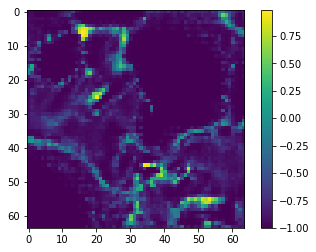

3: 0/409: [D loss: 30.365158] [G loss: 111.137527]
3: 1/409: [D loss: -46.099247] [G loss: 93.971375]
3: 2/409: [D loss: -114.428253] [G loss: -106.766846]
3: 3/409: [D loss: -51.292282] [G loss: 143.025269]
3: 4/409: [D loss: -53.557281] [G loss: -85.612961]
3: 5/409: [D loss: 9.105191] [G loss: 14.640388]
3: 6/409: [D loss: -10.437877] [G loss: 84.180313]
3: 7/409: [D loss: -9.760799] [G loss: 108.533928]
3: 8/409: [D loss: -13.874254] [G loss: 34.010860]
3: 9/409: [D loss: -9.394775] [G loss: -184.409241]
3: 10/409: [D loss: -27.632030] [G loss: 223.858582]
3: 11/409: [D loss: -27.978580] [G loss: 17.672682]
3: 12/409: [D loss: -10.414645] [G loss: -21.607985]
3: 13/409: [D loss: -4.024118] [G loss: 47.057316]
3: 14/409: [D loss: -9.884168] [G loss: 36.180431]
3: 15/409: [D loss: -14.223003] [G loss: -66.209106]
3: 16/409: [D loss: -25.805603] [G loss: 107.496399]
3: 17/409: [D loss: -4.588824] [G loss: -114.885513]
3: 18/409: [D loss: -6.781404] [G loss: 38.364136]
3: 19/409: [D lo

3: 156/409: [D loss: -19.673439] [G loss: -131.206726]
3: 157/409: [D loss: 18.073948] [G loss: 188.430542]
3: 158/409: [D loss: -4.651012] [G loss: 93.166451]
3: 159/409: [D loss: 8.436853] [G loss: 5.605565]
3: 160/409: [D loss: 2.893417] [G loss: 44.810738]
3: 161/409: [D loss: 56.058613] [G loss: 213.027344]
3: 162/409: [D loss: -36.319782] [G loss: -316.328583]
3: 163/409: [D loss: -5.466505] [G loss: 111.569862]
3: 164/409: [D loss: -12.126295] [G loss: 22.222786]
3: 165/409: [D loss: -15.483567] [G loss: -20.969881]
3: 166/409: [D loss: 18.426245] [G loss: 17.333206]
3: 167/409: [D loss: -14.919216] [G loss: 141.388947]
3: 168/409: [D loss: 13.337919] [G loss: 8.768760]
3: 169/409: [D loss: -15.024506] [G loss: -132.625153]
3: 170/409: [D loss: 11.490127] [G loss: -36.449745]
3: 171/409: [D loss: -20.971046] [G loss: 94.795059]
3: 172/409: [D loss: 17.183233] [G loss: -207.339417]
3: 173/409: [D loss: -9.710010] [G loss: 126.547745]
3: 174/409: [D loss: -2.838002] [G loss: -49.9

3: 311/409: [D loss: 4.498551] [G loss: 253.666229]
3: 312/409: [D loss: -0.852170] [G loss: -14.988741]
3: 313/409: [D loss: -18.227634] [G loss: 34.131393]
3: 314/409: [D loss: -22.974783] [G loss: 97.833092]
3: 315/409: [D loss: 5.785688] [G loss: 31.622372]
3: 316/409: [D loss: -2.600830] [G loss: 143.082092]
3: 317/409: [D loss: -1.554281] [G loss: 10.539815]
3: 318/409: [D loss: 6.370924] [G loss: -91.073746]
3: 319/409: [D loss: -5.538668] [G loss: 99.697502]
3: 320/409: [D loss: 8.022291] [G loss: 45.081944]
3: 321/409: [D loss: -9.740011] [G loss: 29.290468]
3: 322/409: [D loss: -8.543820] [G loss: 52.525330]
3: 323/409: [D loss: -1.011492] [G loss: -91.314255]
3: 324/409: [D loss: -0.301839] [G loss: -35.035995]
3: 325/409: [D loss: -13.057349] [G loss: -17.120735]
3: 326/409: [D loss: -10.199319] [G loss: 115.439934]
3: 327/409: [D loss: -9.399271] [G loss: 60.566978]
3: 328/409: [D loss: -13.463275] [G loss: -61.471931]
3: 329/409: [D loss: -2.288441] [G loss: 171.534637]
3

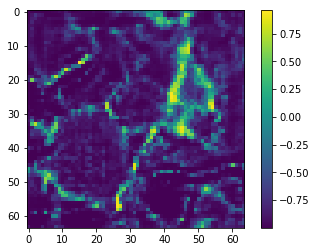

4: 0/409: [D loss: 0.964415] [G loss: 70.384956]
4: 1/409: [D loss: -8.304948] [G loss: -86.195549]
4: 2/409: [D loss: -12.145620] [G loss: -32.345882]
4: 3/409: [D loss: -2.500553] [G loss: 10.086383]
4: 4/409: [D loss: -11.262884] [G loss: 8.503208]
4: 5/409: [D loss: -5.496095] [G loss: 95.826378]
4: 6/409: [D loss: -11.018210] [G loss: 15.776243]
4: 7/409: [D loss: -5.459835] [G loss: 16.133373]
4: 8/409: [D loss: -10.651073] [G loss: -297.052979]
4: 9/409: [D loss: -23.880671] [G loss: 94.824234]
4: 10/409: [D loss: -15.526122] [G loss: 128.581055]
4: 11/409: [D loss: -7.335352] [G loss: -32.213749]
4: 12/409: [D loss: -18.607330] [G loss: 39.337795]
4: 13/409: [D loss: -16.667404] [G loss: 144.048843]
4: 14/409: [D loss: -7.827814] [G loss: -124.234116]
4: 15/409: [D loss: -13.476210] [G loss: -9.270109]
4: 16/409: [D loss: 6.069880] [G loss: 111.742577]
4: 17/409: [D loss: -9.500099] [G loss: -6.269926]
4: 18/409: [D loss: -27.790846] [G loss: 34.405907]
4: 19/409: [D loss: -42.

4: 157/409: [D loss: 12.423053] [G loss: -153.447189]
4: 158/409: [D loss: -55.607372] [G loss: 193.667542]
4: 159/409: [D loss: 11.608742] [G loss: -109.970329]
4: 160/409: [D loss: -0.311542] [G loss: 142.609299]
4: 161/409: [D loss: -31.676271] [G loss: 165.035614]
4: 162/409: [D loss: -14.655446] [G loss: 35.847355]
4: 163/409: [D loss: -9.945225] [G loss: -61.903709]
4: 164/409: [D loss: -6.698092] [G loss: 19.998310]
4: 165/409: [D loss: -11.154539] [G loss: -102.626526]
4: 166/409: [D loss: -23.540407] [G loss: 8.545601]
4: 167/409: [D loss: 2.945328] [G loss: -100.245361]
4: 168/409: [D loss: -22.608301] [G loss: -82.892014]
4: 169/409: [D loss: -11.281004] [G loss: 203.575150]
4: 170/409: [D loss: -8.044916] [G loss: -128.037262]
4: 171/409: [D loss: 0.219786] [G loss: -82.977097]
4: 172/409: [D loss: -24.293385] [G loss: 65.813324]
4: 173/409: [D loss: -9.965433] [G loss: 21.578535]
4: 174/409: [D loss: -6.126327] [G loss: -54.108604]
4: 175/409: [D loss: 16.692263] [G loss: 

4: 312/409: [D loss: -24.378016] [G loss: -177.743317]
4: 313/409: [D loss: -24.199039] [G loss: -61.117100]
4: 314/409: [D loss: -30.455906] [G loss: -136.427597]
4: 315/409: [D loss: 6.925590] [G loss: 22.648407]
4: 316/409: [D loss: -15.346548] [G loss: -10.527930]
4: 317/409: [D loss: -9.041218] [G loss: -9.154202]
4: 318/409: [D loss: -4.771719] [G loss: -55.565895]
4: 319/409: [D loss: -12.583372] [G loss: -108.842781]
4: 320/409: [D loss: 1.333491] [G loss: 20.848190]
4: 321/409: [D loss: -25.272362] [G loss: -159.466690]
4: 322/409: [D loss: 34.584530] [G loss: 126.952805]
4: 323/409: [D loss: -8.754970] [G loss: -41.549423]
4: 324/409: [D loss: -7.550237] [G loss: 142.652557]
4: 325/409: [D loss: -10.447312] [G loss: -53.699833]
4: 326/409: [D loss: -5.729997] [G loss: 23.473097]
4: 327/409: [D loss: -9.398387] [G loss: -3.809198]
4: 328/409: [D loss: 1.681218] [G loss: -55.148613]
4: 329/409: [D loss: -19.796013] [G loss: 161.711319]
4: 330/409: [D loss: -14.264964] [G loss: 

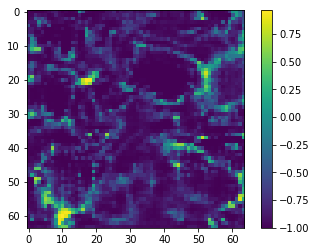

5: 0/409: [D loss: -1.569294] [G loss: -65.935104]
5: 1/409: [D loss: -2.949965] [G loss: 92.049759]
5: 2/409: [D loss: 1.917957] [G loss: -172.097885]
5: 3/409: [D loss: -0.446617] [G loss: 1.242804]
5: 4/409: [D loss: -2.254947] [G loss: -45.363781]
5: 5/409: [D loss: -7.887888] [G loss: 78.909195]
5: 6/409: [D loss: -10.871012] [G loss: -43.707310]
5: 7/409: [D loss: 11.679498] [G loss: -59.189537]
5: 8/409: [D loss: -10.443649] [G loss: -21.929188]
5: 9/409: [D loss: -2.198721] [G loss: 3.127179]
5: 10/409: [D loss: -1.994502] [G loss: 21.157009]
5: 11/409: [D loss: -11.285361] [G loss: 8.945238]
5: 12/409: [D loss: -1.449620] [G loss: -38.806160]
5: 13/409: [D loss: -7.138881] [G loss: -27.080700]
5: 14/409: [D loss: -13.973429] [G loss: -24.899399]
5: 15/409: [D loss: -13.560277] [G loss: -72.891319]
5: 16/409: [D loss: -16.446209] [G loss: 88.789169]
5: 17/409: [D loss: -7.985610] [G loss: -123.236420]
5: 18/409: [D loss: 1.696956] [G loss: -285.947113]
5: 19/409: [D loss: -14.6

In [ ]:
# Train the darn thing
batch_size = 8
if ngpus > 1:
    batch_size = batch_size*ngpus
epochs = 25
n_critic = 5

n_samps = delta.shape[0]

# Adversarial ground truths
valid = -np.ones((batch_size, 1))
fake =  np.ones((batch_size, 1))
dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty

d_hist = []
g_hist = []
for epoch in range(epochs):
    
    choice = np.arange(n_samps)
    np.random.shuffle(choice)
    
    niter = len(choice)//batch_size//n_critic
    
    for it in range(niter):
    
        for ic in range(n_critic):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Get some true images
            s0 = it*batch_size*n_critic + ic*batch_size
            s1 = it*batch_size*n_critic + (ic+1)*batch_size
            imgs = delta[choice[s0:s1]]
            imgs = imgs.reshape((batch_size, img_rows, img_cols, img_depth, 1))
            
            #Random reflections
            if np.random.uniform() >= 0.5:
                imgs = imgs[:, ::-1]
            if np.random.uniform() >= 0.5:
                imgs = imgs[:, :, ::-1]
            if np.random.uniform() >= 0.5:
                imgs = imgs[:, :, :, ::-1]

            # Sample generator input
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            # Train the critic
            d_loss = critic_model.train_on_batch([imgs, noise],
                                                 [valid, fake, dummy])

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = generator_model.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d: %i/%i: [D loss: %f] [G loss: %f]" % 
               (epoch, it, niter, d_loss[0], g_loss))

        d_hist.append(d_loss[0])
        g_hist.append(g_loss)

    test_img = generator.predict(np.random.normal(0, 1, (1, latent_dim))).reshape(img_shape)
    clf()
    imshow(test_img[32, :, :, 0])
    colorbar()
    display.display(gcf())
    

Text(0.5,0,'Iteration')

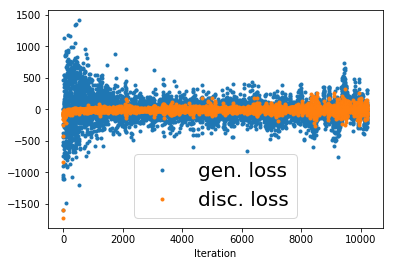

In [25]:
#critic1 - Adam - 4 levels
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Iteration')
#ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')
#ylim(-250, 250)

Text(0.5,0,'Iteration')

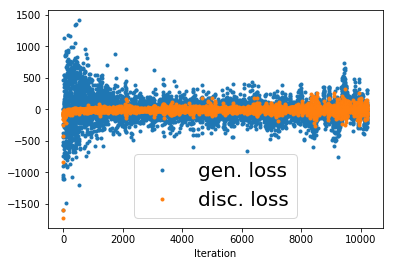

In [24]:
#critic1 - Adam - 4 levels
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Iteration')
#ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')
#ylim(-250, 250)

Text(0.5,0,'Iteration')

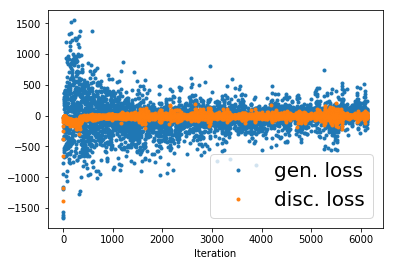

In [48]:
#critic1 - Adam - 4 levels
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Iteration')
#ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')
#ylim(-250, 250)1

Text(0.5,0,'Iteration')

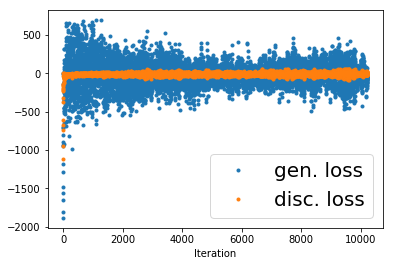

In [40]:
#critic1 - Adam - 4 levels
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Iteration')
#ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')
#ylim(-250, 250)

(-250, 250)

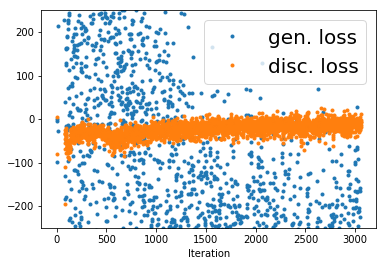

In [27]:
#critic1 - RMSprop - 4 levels
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Iteration')
#ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')
#ylim(-250, 250)

(-1000, 1000)

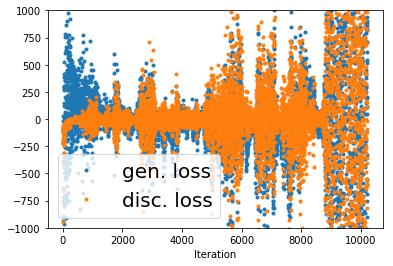

In [30]:
#critic1 - RMSprop - 4 levels
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Iteration')
#ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')
ylim(-1000, 1000)

Text(0.5,0,'Iteration')

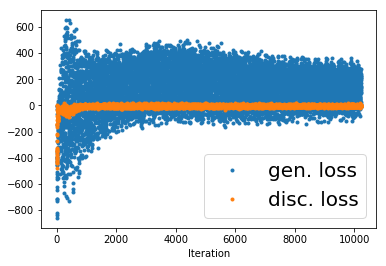

In [46]:
#critic1 - RMSprop
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Iteration')
#ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Iteration')

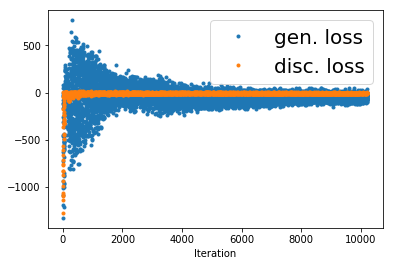

In [36]:
#critic2 - RMSprop
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Iteration')
#ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Iteration')

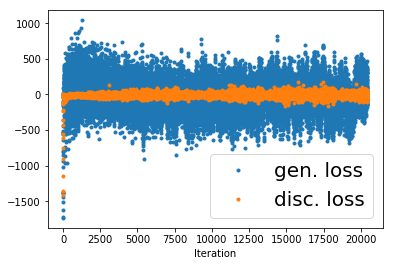

In [25]:
#critic3 - Adam2 - squashed
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Iteration')
#ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')

(-100, 100)

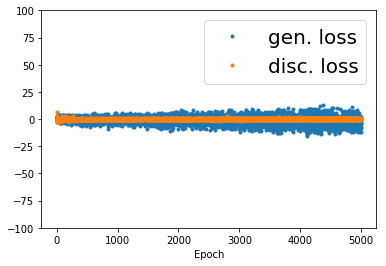

In [35]:
#critic3 - Adam2 - squashed
#plot(np.sqrt(np.array(d_hist)**2 + np.array(g_hist)**2), '.', label='total loss', c='grey')
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
ylim(-100, 100)
#plot(np.array(g_hist) + np.array(d_hist), '.')

(-1000, 1000)

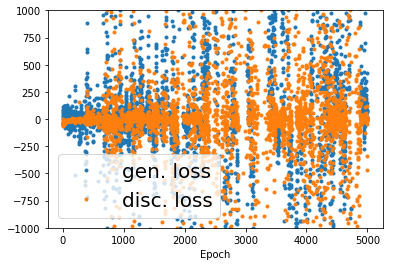

In [71]:
#critic3 - Adam2
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
ylim(-1000, 1000)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

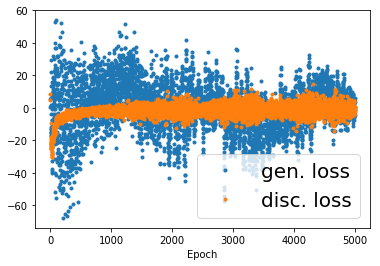

In [58]:
# New critic - Adam2
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

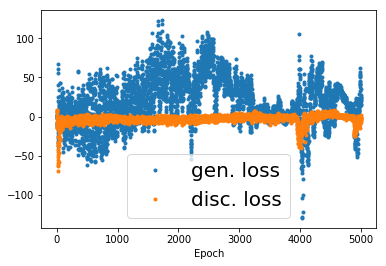

In [47]:
# New critic - Adam
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

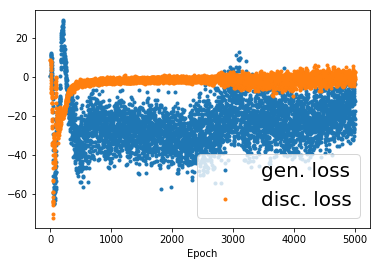

In [37]:
# New critic - RMSprop
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

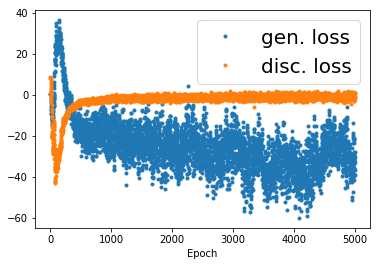

In [37]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

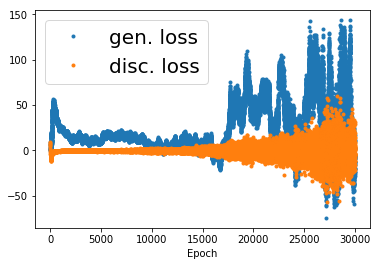

In [107]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

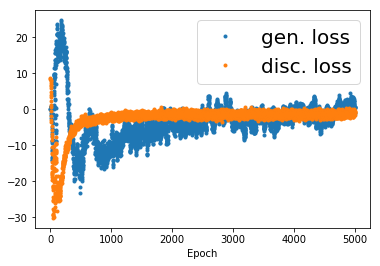

In [77]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

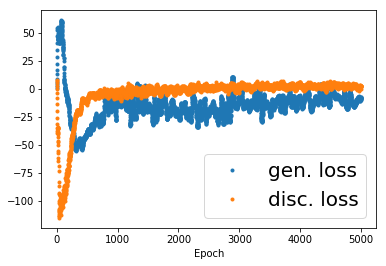

In [61]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

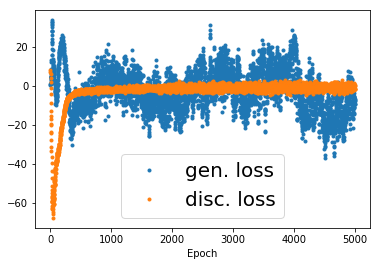

In [48]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

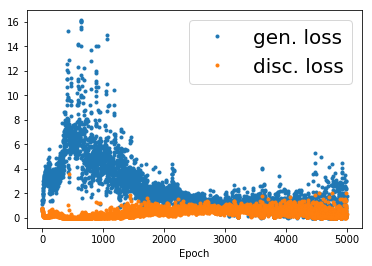

In [33]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

Text(0.5,0,'Epoch')

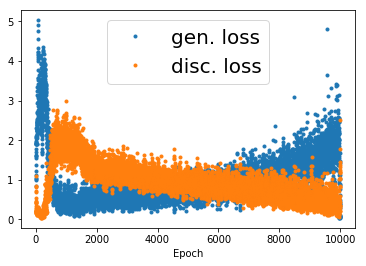

In [13]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

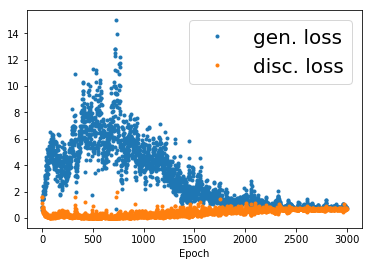

In [111]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

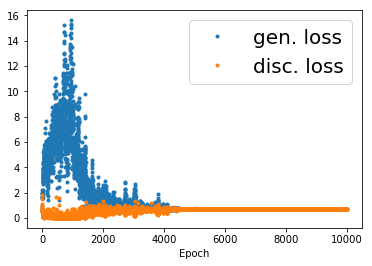

In [102]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

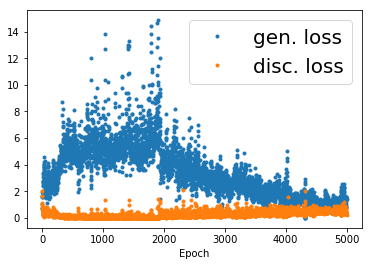

In [218]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

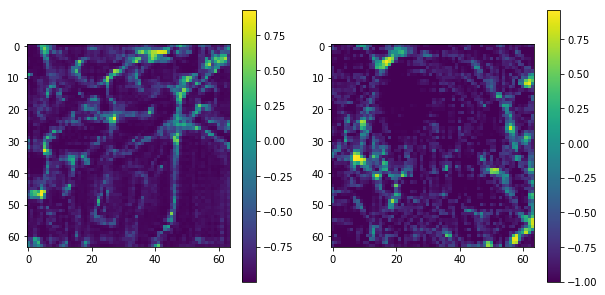

In [26]:
fig = figure(figsize = (10, 5))

test_imgs = []
real_imgs = []
for i in range(32):
    test_imgs.append(generator.predict(np.random.normal(0, 1, (1, latent_dim))).reshape(64, 64, 64))
real_imgs = delta[:32]
    
test_imgs = np.array(test_imgs)
real_imgs = np.array(real_imgs)

subplot(1,2,1)
imshow(test_imgs[0, 32])
colorbar()
subplot(1,2,2)
imshow(real_imgs[0, 32])
#print(np.std(real_imgs.reshape(32, -1), axis=-1).mean(), np.mean(real_imgs.reshape(32, -1), axis=-1).mean())
#print(np.std(test_img.reshape(32, -1), axis=-1).mean(), np.mean(test_imgs.reshape(32, -1), axis=-1).mean())
colorbar()

In [27]:
def estimate_pk(kki, img, nbin=30):
    
    bins = np.linspace(np.min(kki), np.max(kki), nbin+1, endpoint=True)

    ibin = [np.logical_and(kki.ravel() >= bins[i], kki.ravel() < bins[i+1]) for i in range(nbin)]
    ibin = np.array(ibin)

    ft = abs(np.fft.fftn(img))**2
    pkk = np.array([np.mean(ft.ravel()[ibin[i]]) for i in range(nbin)])
    kk = np.array([np.mean(kki.ravel()[ibin[i]]) for i in range(nbin)])

    return kk, pkk

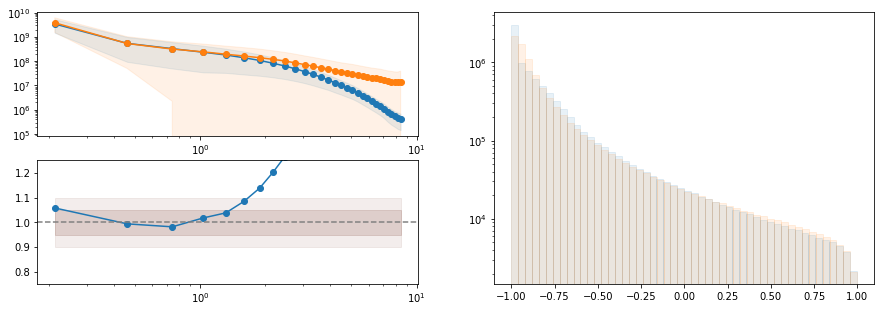

In [30]:
fig = figure(figsize = (15, 5))

kx = np.fft.fftfreq(64, d=0.1)
ky = np.fft.fftfreq(64, d=0.1)
kz = np.fft.fftfreq(64, d=0.1)
kk = np.sqrt(kx[:, np.newaxis, np.newaxis]**2 
             + ky[np.newaxis, :, np.newaxis]**2 
             + kz[np.newaxis, np.newaxis, :]**2)

pk1r = []
pk2f = []
for i in range(32):
    k1, pk1 = estimate_pk(kk, squash_inv(real_imgs[i]))
    k2, pk2 = estimate_pk(kk, squash_inv(test_imgs[i]))
    #k1, pk1 = estimate_pk(kk, real_imgs[i])
    #k2, pk2 = estimate_pk(kk, test_imgs[i])

    pk1r.append(pk1)
    pk2f.append(pk2)
pk1r = np.array(pk1r)
pk2f = np.array(pk2f)

subplot(2,2,1)
plot(k1, pk1r.mean(0), '-o')
fill_between(k1, pk1r.mean(0) - pk1r.std(0), pk1r.mean(0) + pk1r.std(0), color='C0', alpha=0.1)
plot(k2, pk2f.mean(0), '-o')
fill_between(k2, pk2f.mean(0) - pk2f.std(0), pk2f.mean(0) + pk2f.std(0), color='C1', alpha=0.1)
yscale('log')
xscale('log')
subplot(2,2,3)
plot(k1, np.sqrt(pk2f.mean(0)/pk1r.mean(0)), '-o')
krange = np.linspace(np.min(k1), np.max(k1), 100)
fill_between(krange, np.ones_like(krange)*0.9, np.ones_like(krange)*1.1, color='C5', alpha=0.1)
fill_between(krange, np.ones_like(krange)*0.95, np.ones_like(krange)*1.05, color='C5', alpha=0.2)
axhline(1.0, ls='--', c='grey')
xscale('log')
ylim(0.75, 1.25)

subplot(1,2,2)
foo = hist((real_imgs).ravel(), bins=50, edgecolor='C0', alpha=0.1)
foot = hist((test_imgs).ravel(), bins=50, edgecolor='C1', alpha=0.1)
#foo = hist(squash_inv(real_imgs).ravel(), bins=50, edgecolor='C0', alpha=0.1)
#foot = hist(squash_inv(test_imgs).ravel(), bins=50, edgecolor='C1', alpha=0.1)
yscale('log')

0.0 1.0
0.041711114 1.4031054


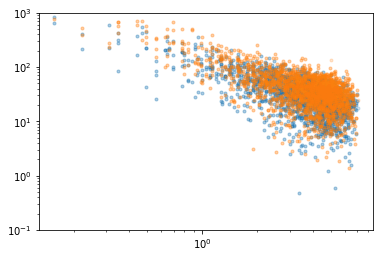

In [26]:
real_sample = grf_2d(1.0, alpha=-2.0)
plot(kk.ravel(), abs(np.fft.fft2(real_sample)).ravel(), '.', alpha=0.2)

plot(kk.ravel(), abs(np.fft.fft2(test_img)).ravel(), '.', alpha=0.2)
yscale('log')
xscale('log')
ylim(1e-1, 1e3)

print(np.mean(real_sample), np.std(real_sample))
print(np.mean(test_img), np.std(test_img))

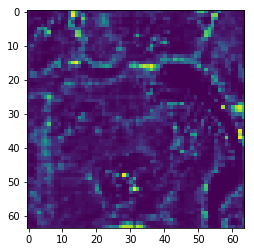

In [38]:
imshow(test_imgs[0, 37])